## Importing Dependencies

In [ ]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd
from datetime import datetime as dt

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

## Challenge 1: Loading the Data and Exploring it

In [ ]:
# URL: http://web.mta.info/developers/turnstile.html

def get_data(week_nums):
    url = "data/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
        # dfs.append(pd.read_csv(file_url, parse_dates=[['DATE','TIME']], keep_date_col=True))
    return pd.concat(dfs)
        
week_nums = [200912, 200919, 200926]
mta_data_raw = get_data(week_nums)

In [ ]:
mta_data_raw.shape

In [ ]:
mta_data_raw.describe()  # descriptive stats for numeric variables

In [ ]:
mta_data_raw.describe(include=['O'])   # descriptive stats for other (categorical, string) variables

In [ ]:
mta_data_raw.DESC.value_counts()

In [ ]:
mta_data_raw.dtypes

In [ ]:
mta_data_raw.columns

In [ ]:
mta_data_raw.columns = [column.strip() for column in mta_data_raw.columns]
mta_data_raw.columns

In [ ]:
mta_data_raw.head()

In [ ]:
mta_data_raw.tail()

In [ ]:
mta_data_raw.reset_index()

In [ ]:
mta_data_raw.DATE.value_counts().sort_index()

## Challenge 2: Changing DATE and TIME objects to TIMESERIES

In [ ]:
mta_data_raw["DATE_TIME"] = pd.to_datetime(mta_data_raw.DATE + " " + mta_data_raw.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [ ]:
mta_data_raw.head()

## Challenge 3: Daily Entries For Each Turnstile
<font color=blue>Each row is a turnstile, identified by a combination of the C/A, UNIT, SCP, and STATION columns, with information on entries and exits at that turnstile every n hours. (What is n?). We want total daily entries.  
Group the data so that it represents daily entries for each turnstile (hint: pd.groupby or DataFrame.groupby).</font>

So far,  
  1. Loaded data (and checked shape, describe, describe(include=['O]), columns, column-dtypes, head, tail, index_reset, DATE value counts)
  2. Created DATE_TIME (time-series) object from DATE and TIME string objects.  

Now,
  3. Find total number of daily entries at each turnstile.  

(1) and (2) did not involve measuring any column ~ did not require cleaning or pre-processing the data.  
(3) Finding total number of daily entries at each turnstile, requires some cleaning and processing of the data.  

**How to find total daily ENTRIES at each turnstile?**  

  1. Each turnstile is identified by the combination of ['C/A', 'UNIT', 'SCP', 'STATION'] columns.
  2. The ENTRIES are registered at each turnstile for EVERY FOUR HOURS.
  3. Grouping ENTRIES at each turnstile using ['C/A', 'UNIT', 'SCP', 'STATION'] and ['DATE_TIME'] columns will result in multiple rows for a given day.
  4. We then have to add up four-hour ENTRIES within a group to get 24-hour ENTRIES.  
    * While doing so we need to make sure there aren't any duplicates (of four-hour entries).
    * NOTE that we have already checked for the missing values.  

In [ ]:
# (mta_data_raw
#  .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
#  .ENTRIES.count()
#  .reset_index()
#  .sort_values("ENTRIES", ascending=False)).head(5)
# for easy reference below, consider:
# grouped_df = mta_data_raw.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE_TIME'])


## groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE_TIME']):
    # group mta_data_raw for each turnstile for every four hours

## grouped_df.ENTRIES.count():
    # gives number of ENTRIES registered at each turnstile for every four hours (ideally should be one)

    # type(grouped_df.ENTRIES.count()) = Series

## .reset_index():
    # type(grouped_df.ENTRIES.count()) = Series; 
    # Series.reset_index() is useful when the index needs to be treated as a column or when the index 
    # is meaningless & needs to be reset to the default before another operation. When drop is False 
    # (the default), a DataFrame is returned. The newly created columns will come first in the DataFrame, 
    # followed by the original Series values. When drop is True, a Series is returned. In either case, 
    # if inplace=True, no value is returned.

    # grouped_df.ENTRIES.count().index.names = FrozenList(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE_TIME']) 
    # grouped_df.ENTRIES.count().head(20): check screen_shots document
    # type(grouped_df.ENTRIES.count().reset_index()) = DataFrame ****   
    # grouped_df.ENTRIES.count().reset_index().head(20): check screen_shots document
    
## .sort_values("ENTRIES", ascending=False))
    # Returns a DataFrame with sorted values if inplace=True; else None.
    # Sorts 'by' first argument (here, ENTRIES) in the ascending order.
    # ENTRIES columns here contains the number of ENTRIES registered for each turnstile for every four hours 
    # and not the original ENTRIES column values.
    # Ideally ENTRIES should contain values of 1 (implying only one registered entry for ENTRIES at the 
    # turnstile for given four hour interval).
    # Any value greater than 1 implies existing of duplicate entries for ENTRIES column for that turnstile at 
    # that given four hour interval.
    # Sorting the ENTRIES column here (number of registered entries for the ENTRIES column for each turnstile 
    # for given four hour interval) in the ascending order will display those which have duplicate entries.
    
# .head()

In [ ]:
# Grouping ENTRIES for each turnstile over each DATE_TIME entry (four-hour)
(mta_data_raw
 .groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE_TIME'])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)
 .head(20))

In [ ]:
# Getting rid of duplicate values

# Sort mta dataset by turnstile and date_time in the descending order.
# This means the top row in each group will have the last entry for ENTRIES for the day
# And also for dupplicate entries (having same DATE_TIME value) the DESC=RECOVR AUD will come later 
# (comapred to corresponding DESC=REGULAR) because of alphabetical order (REGULAR comes before RECOVER AUD for descending order)
mta_data_raw.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True, ascending=False)

# Here we are only dropping the entries where DESC=RECOVER AUD
mta_data_raw.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [ ]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(mta_data_raw
 .groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE_TIME'])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)
 .head(5))

In [ ]:
# Drop Exits and Desc Column.  To prevent errors in multiple run of cell, errors on drop is ignored
mta_data_raw = mta_data_raw.drop(["EXITS", "DESC"], axis=1, errors="ignore")

In [ ]:
mta_data_raw.tail(10)

If we go back couple of steps, as shown above, 'mta_data_raw' has been sorted in the descending order of ['C/A', 'UNIT', 'SCP', 'STATION', 'DATE_TIME']. This dataset is free of duplicates and the first row for every turnstile now gives the ENTRIES up to the last four-hour period of the day.  

.groupby.first() can be used on a groupby object to pull the first row of every DataFrameGroupBy object. However if we stick to grouping using columns ['C/A', 'UNIT', 'SCP', 'STATION', 'DATE_TIME'] every unique four-hour timestamp will be a qroup by itself. Hence we re-group rows using the columns ['C/A', 'UNIT', 'SCP', 'STATION', 'DATE']. So that we pick the top row for each date.

To get the total number of ENTRIES for each day, we will still have to subtract, from the cumulative ENTRIES up to  that day, the cumulative ENTRIES up to the previous day.  

In [ ]:
# To get the ENTRIES for each 

mta_data_daily = (mta_data_raw
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())
mta_data_daily.head()

In [ ]:
# The values in ENTRIES column are cumulative. 
# Number of entries for a single day = current_day_ENTRIES - previous_day_ENTRIES
# We use Series.shift() function for this purpose.
mta_data_daily[["PREV_DATE", "PREV_ENTRIES"]] = (mta_data_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       .apply(lambda x: x.shift(1)))
#mta_data_daily[['PREV_DATE','PREV_ENTRIES']] = mta_data_daily[['DATE','ENTRIES']].apply(lambda x: x.shift(1)) # MESSED THE DATA, HAVE TO INVESTIGATE WHY THIS DID NOT WORK

In [ ]:
mta_data_daily.head()

In [ ]:
# Drop the rows for the earliest date in the df
mta_data_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [ ]:
mta_data_daily.head()

Before rushing to find the delta between the ENTRIES and PREV_ENTRIES for a given day, we check if there are any anomalies. In this case having ENTRIES < PREV_ENTRIES would be an anomaly.

In [ ]:
# Checking if any of the previous ENTRIES are more than the current ENTRIES

mta_data_daily[mta_data_daily['ENTRIES'] < mta_data_daily['PREV_ENTRIES']].shape

In [ ]:
mta_data_daily[mta_data_daily['ENTRIES'] < mta_data_daily['PREV_ENTRIES']].head()

In [ ]:
# Checking the data for the above turnstile from original dataset.

filt = ((mta_data_raw['C/A'] == 'A011') &
        (mta_data_raw['UNIT'] == 'R080') &
        (mta_data_raw['SCP'] == '01-03-00') &
        (mta_data_raw['STATION'] == '57 ST-7 AV') &
        (mta_data_raw['DATE_TIME'].dt.date == datetime.datetime(2020, 9, 6).date()))

mta_data_raw[filt].head()

In [ ]:
# Checking how many stations have this problem

filt = (mta_data_daily['ENTRIES'] < mta_data_daily['PREV_ENTRIES'])

# .size(): outputs number of rows in each group as a Series/DataFrame.
mta_data_daily[filt].groupby(['C/A', 'UNIT', 'SCP', 'STATION']).size()  

In [ ]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
mta_data_daily["DAILY_ENTRIES"] = mta_data_daily.apply(get_daily_counts, axis=1, max_counter=500000)

In [ ]:
mta_data_daily["DAILY_ENTRIES"].head()

In [ ]:
mta_data_daily.head(25)

### Challenge 4: Plot the daily time series for a single turnstile.

In [ ]:
# Total number of turnstiles
len(mta_data_daily.groupby(['C/A', 'UNIT', 'SCP', 'STATION']))

In [ ]:
# Series of mean entries at each turnstile (over a period of three weeks)
turnstile_mean_entries = mta_data_daily.groupby(['C/A', 'UNIT', 'SCP', 'STATION']).DAILY_ENTRIES.mean()

In [ ]:
# Maximum mean entries
max_mean_entries = mta_data_daily.groupby(['C/A', 'UNIT', 'SCP', 'STATION']).DAILY_ENTRIES.mean().max()

In [ ]:
# Turnstile with maximum mean entries
turnstile_max_mean_entries = mta_data_daily.groupby(['C/A', 'UNIT', 'SCP', 'STATION']).DAILY_ENTRIES.mean().idxmax()

In [205]:
mta_data_daily.groupby(['C/A', 'UNIT', 'SCP', 'STATION']).head()

C/A  UNIT       SCP        STATION        DATE  ENTRIES   PREV_DATE  \
1        A002  R051  02-00-00          59 ST  09/06/2020  7454567  09/05/2020   
2        A002  R051  02-00-00          59 ST  09/07/2020  7454925  09/06/2020   
3        A002  R051  02-00-00          59 ST  09/08/2020  7455427  09/07/2020   
4        A002  R051  02-00-00          59 ST  09/09/2020  7456007  09/08/2020   
5        A002  R051  02-00-00          59 ST  09/10/2020  7456494  09/09/2020   
...       ...   ...       ...            ...         ...      ...         ...   
103808  TRAM2  R469  00-05-01  RIT-ROOSEVELT  09/06/2020     5554  09/05/2020   
103809  TRAM2  R469  00-05-01  RIT-ROOSEVELT  09/07/2020     5554  09/06/2020   
103810  TRAM2  R469  00-05-01  RIT-ROOSEVELT  09/08/2020     5554  09/07/2020   
103811  TRAM2  R469  00-05-01  RIT-ROOSEVELT  09/09/2020     5554  09/08/2020   
103812  TRAM2  R469  00-05-01  RIT-ROOSEVELT  09/10/2020     5554  09/09/2020   

        PREV_ENTRIES  DAILY_ENTRIES  
1          7454267.0          300.0  
2          7454567.0          358.0  
3          7454925.0          502.0  
4          7455427.0          580.0  
5          7456007.0          487.0  
...              ...            ...  
103808        5554.0            0.0  
103809        5554.0            0.0  
103810        5554.0            0.0  
103811        5554.0            0.0  
103812        5554.0            0.0  

[24807 rows x 9 columns]

In [204]:
# Filtering for turnstile with max mean entries.

filt = ((mta_data_daily['C/A'] == 'A002') &
        (mta_data_daily['UNIT'] == 'R051') &
        (mta_data_daily['SCP'] == '02-00-00') &
        (mta_data_daily['STATION'] == '59 ST'))

single_turnstile = mta_data_daily[filt]

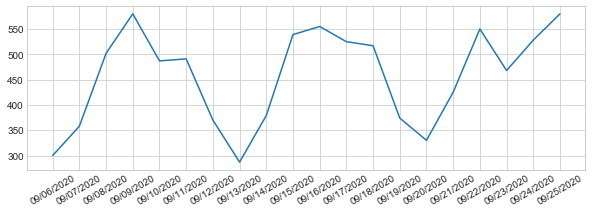

In [208]:
plt.figure(figsize=(10,3))
plt.xticks(rotation=30)
plt.plot(single_turnstile['DATE'],single_turnstile['DAILY_ENTRIES'])

### Plotting the distribution of each feature

In [ ]:
# def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
#     '''
#     Plots distribution of each feature in the given dataset. A countplot for np.objects 
#     (non-numeric data types). A histplot for numeric objects.
    
#     Args: dataset, number of columns, width, height, hspace and wspace of matplotlib plot.
    
#     Returns: countplot for non-numeric columns and histplot for numeric columns of the dataset.
#     '''
#     plt.style.use('seaborn-whitegrid')             
#     fig = plt.figure(figsize=(width, height))      
#     fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
#     rows=math.ceil(float(dataset.shape[1]/cols))
#     for i, column in enumerate(dataset.columns):
#         ax = fig.add_subplot(rows, cols, i+1)
#         ax.set_title(column)
#         if dataset.dtypes[column]==np.object:
#             g = sns.countplot(y=column, data=dataset)
#             substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
#             g.set(yticklabels=substrings)
#             plt.xticks(rotation=25)
#         else:
#             g = sns.histplot(dataset[column])
#             plt.xticks(rotation=25)

# plot_distribution(mta_data_raw[['DESC']], cols=3, width=40, height=10, hspace=0.45, wspace=0.5)    

In [209]:
df = pd.DataFrame([['a', 'b', 'c', 5, 1, 10],
                   ['a', 'b', 'c', 5, 2, 24],
                   ['a', 'b', 'c', 5, 3, 15],
                   ['a', 'b', 'c', 6, 1, 8],
                   ['a', 'b', 'c', 6, 2, 16],
                   ['a', 'b', 'c', 6, 3, 12],
                   ['x', 'y', 'z', 5, 1, 14],
                   ['x', 'y', 'z', 6, 1, 25],
                   ['m', 'n', 'o', 5, 1, 30],
                   ['m', 'n', 'o', 5, 2, 17],
                   ['m', 'n', 'o', 6, 1, 28],
                   ['m', 'n', 'o', 6, 2, 4]
                  ], 
                 columns=['C/A', 'UNIT', 'STATION', 'DATE', 'SCP', 'DAILY_ENTRIES'])
df

C/A UNIT STATION  DATE  SCP  DAILY_ENTRIES
0    a    b       c     5    1             10
1    a    b       c     5    2             24
2    a    b       c     5    3             15
3    a    b       c     6    1              8
4    a    b       c     6    2             16
5    a    b       c     6    3             12
6    x    y       z     5    1             14
7    x    y       z     6    1             25
8    m    n       o     5    1             30
9    m    n       o     5    2             17
10   m    n       o     6    1             28
11   m    n       o     6    2              4

In [212]:
df.groupby(['C/A', 'UNIT', 'STATION', 'DATE'])['DAILY_ENTRIES'].sum()

C/A  UNIT  STATION  DATE
a    b     c        5       49
                    6       36
m    n     o        5       47
                    6       32
x    y     z        5       14
                    6       25
Name: DAILY_ENTRIES, dtype: int64